# Twitch income EDA

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import requests
import time

%matplotlib inline

In [3]:
data = pd.read_csv('./data/twitch_stats_income.txt', sep=' ', on_bad_lines='warn')

def get_twitch_stats():
  df = pd.DataFrame(columns=['rank','login','user_id','income','view_count','followers_total','created_at'])
  for rank, login, user_id, income in data.values:
    headers = {
      'Authorization': 'Bearer ***',
      'Client-Id': '***'
    }
    res = requests.get('https://api.twitch.tv/helix/users?id='+str(user_id), headers=headers)
    user_stats = res.json()
    if len(user_stats.get('data')) == 0:
      print('Skipping '+login)
      continue
    view_count = user_stats.get('data')[0].get('view_count')
    created_at = user_stats.get('data')[0].get('created_at')
    broadcaster_type = user_stats.get('data')[0].get('broadcaster_type')

    res = requests.get('https://api.twitch.tv/helix/users/follows?to_id='+str(user_id), headers=headers)
    followers_stats = res.json()
    followers_total = followers_stats.get('total')
    df = df.append(pd.DataFrame([[
      rank, login, user_id, income, view_count, followers_total, created_at
    ]], columns=['rank','login','user_id','income','view_count','followers_total','created_at']))
    time.sleep(0.5)

  with open('./data/full_stats.csv', 'w') as f:
    f.write(df.to_csv())

# get_twitch_stats()

## Stats

In [4]:
full_data = pd.read_csv('./data/combined_stats_2.csv', on_bad_lines='warn')
full_data['created_at'] = pd.to_numeric(pd.to_datetime(full_data['created_at']))

print('Trimmed income mean:', stats.trim_mean(full_data['income'], 0.2), '$')

Trimmed income mean: 63034.37124755062 $


array([[<AxesSubplot:title={'center':'income'}>]], dtype=object)

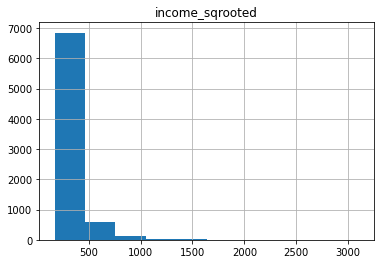

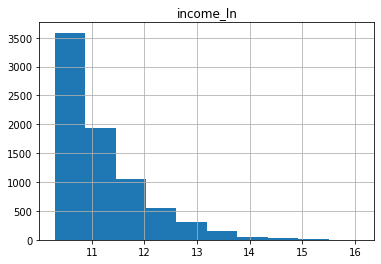

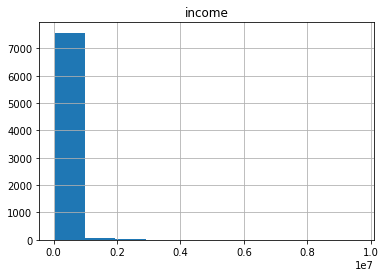

In [5]:
full_data['income_sqrooted'] = full_data['income'] ** 0.5
full_data['income_ln'] = np.log(full_data['income'])

full_data.hist(column='income_sqrooted')
full_data.hist(column='income_ln')
full_data.hist(column='income')

<AxesSubplot:xlabel='followers_total', ylabel='avg_view'>

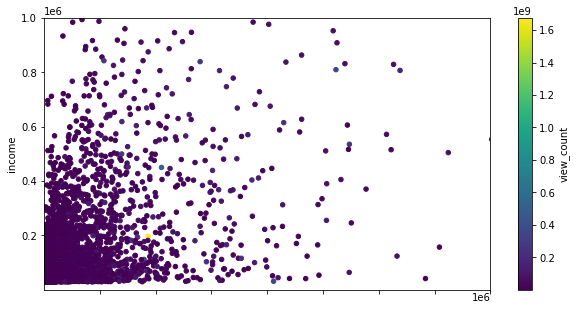

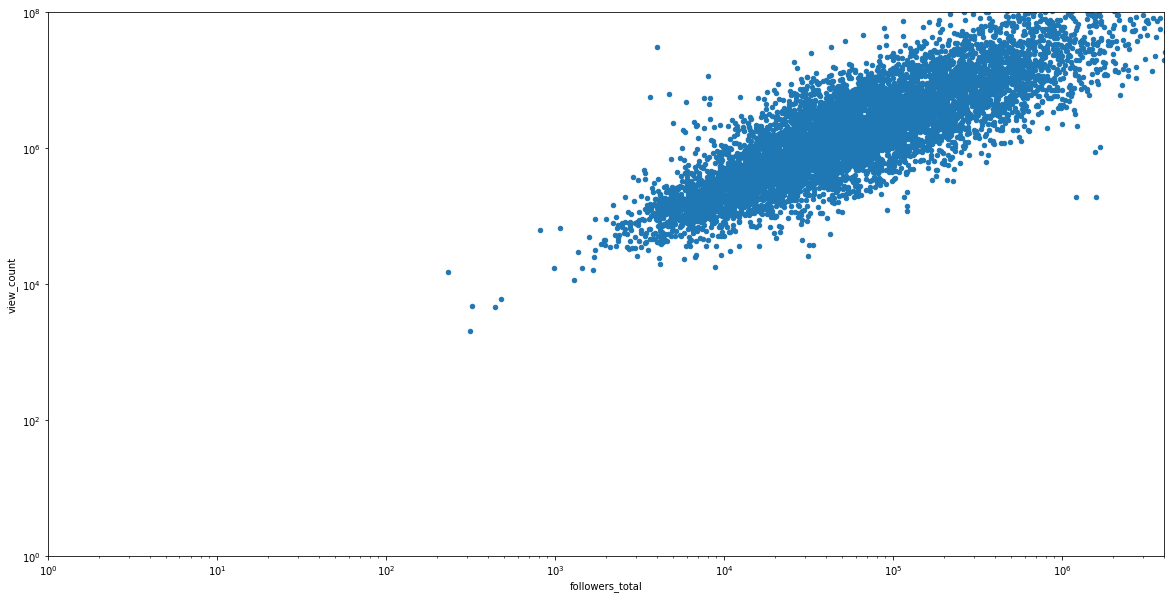

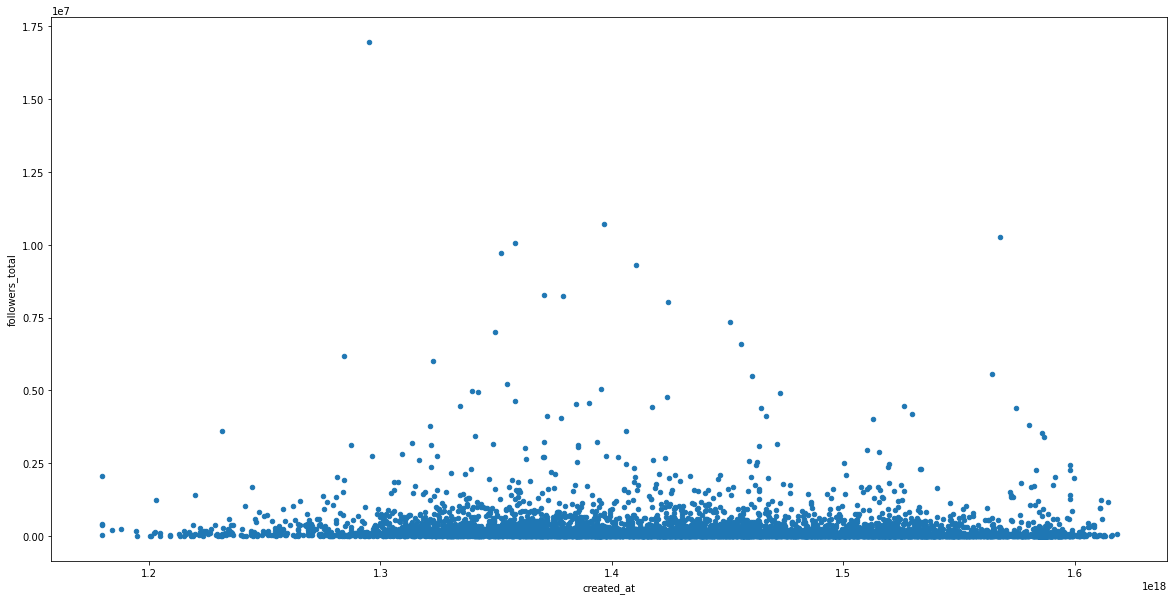

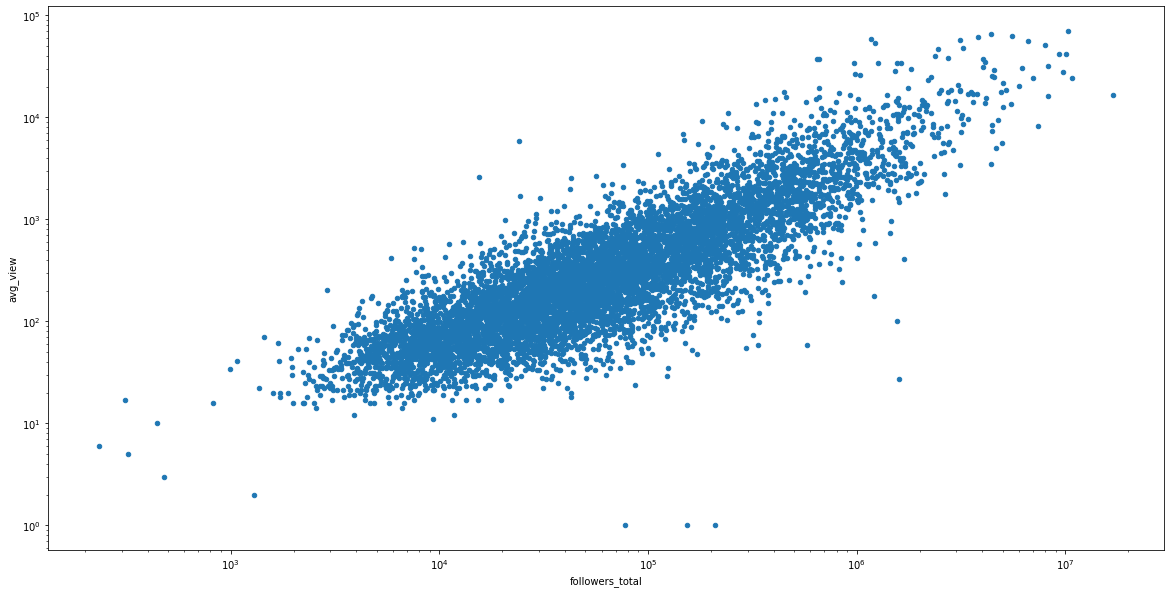

In [6]:
# sns.displot(full_data['view_count'])
full_data.plot.scatter(
  x='followers_total',
  y='income',
  c='view_count',
  xlim=(1, 4000000),
  ylim=(1, 1000000),
  colormap='viridis',
  figsize=(10,5),
)

full_data.plot.scatter(
  x='followers_total',
  y='view_count',
  xlim=(1, 4000000),
  ylim=(1, 100000000),
  figsize=(20,10),
  logx=True,
  logy=True,
)

full_data.plot.scatter(
  x='created_at',
  y='followers_total',
  figsize=(20,10),
)

full_data.plot.scatter(
  x='followers_total',
  y='avg_view',
  figsize=(20,10),
  logx=True,
  logy=True,
)

/var/folders/q7/5h3_bhz90vb4h0hngvk26txh0000gn/T/ipykernel_29450/335954903.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('Russian streamers with income greater 130 000$:\n', full_data[full_data['income'] > 130_000][full_data['lang'] == 'russian'].head(15))
/var/folders/q7/5h3_bhz90vb4h0hngvk26txh0000gn/T/ipykernel_29450/335954903.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('Russian followers above 800k:\n', full_data[full_data['followers_total'] >= 800_000][full_data['lang'] == 'russian'].head(15))


Russian streamers with income greater 130 000$:
       rank         login   user_id     income  view_count  followers_total  \
593    605  HellYeahPlay  76441880  278270.39    20872080           180828   
634    648   KarmikKoala  54742538  262640.87    23168119           170466   
895    918   WELOVEGAMES  30814134  199014.74   115785674           438858   
1195  1231         AkTep  49495142  154591.41    23307974           271948   
1450  1493      BlackUFA  98742675  131670.76    54639673           298626   

               created_at  peak_view  avg_view  active_days  airtime   status  \
593   1417571932000000000       5012      1165          755     9408  partner   
634   1389379429000000000      10980      1984          647     4997  partner   
895   1338031106000000000      29129      2080          697     7147  partner   
1195  1380284001000000000       6300      1289          600     4037  partner   
1450  1439144377000000000      12827      3128          598     3979  partner

<AxesSubplot:title={'center':'income'}, xlabel='status'>

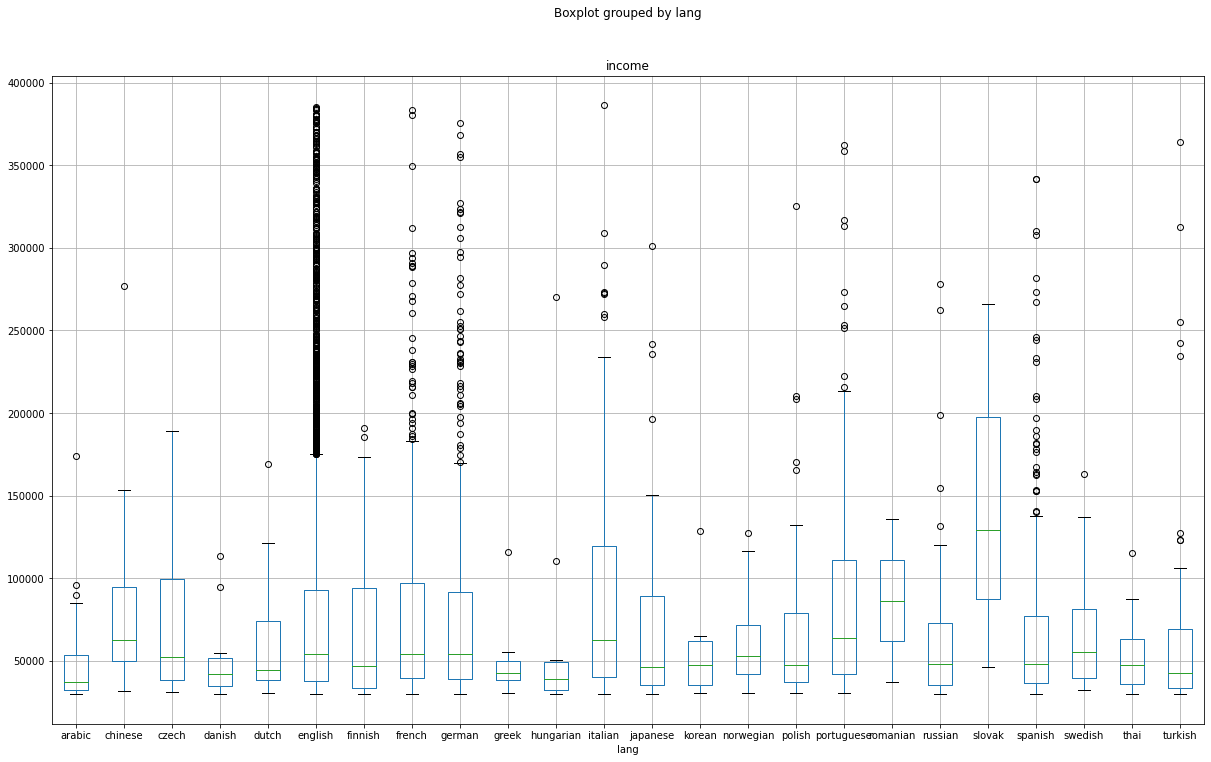

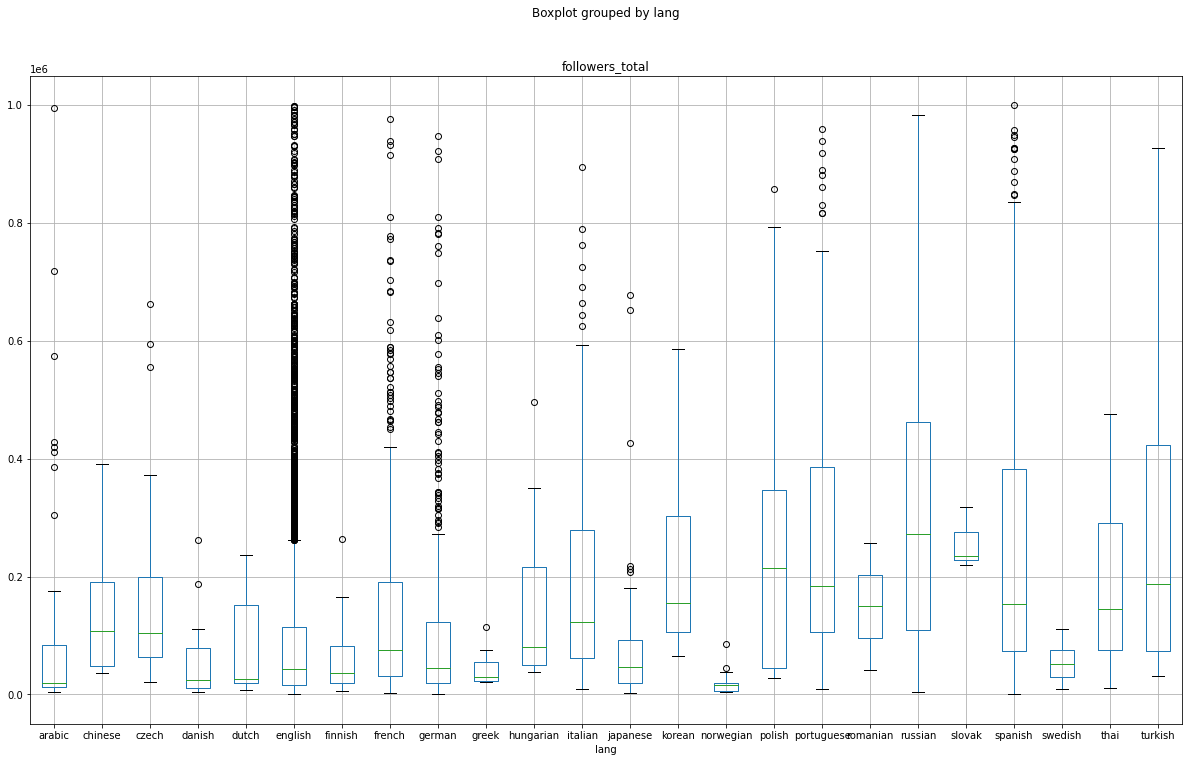

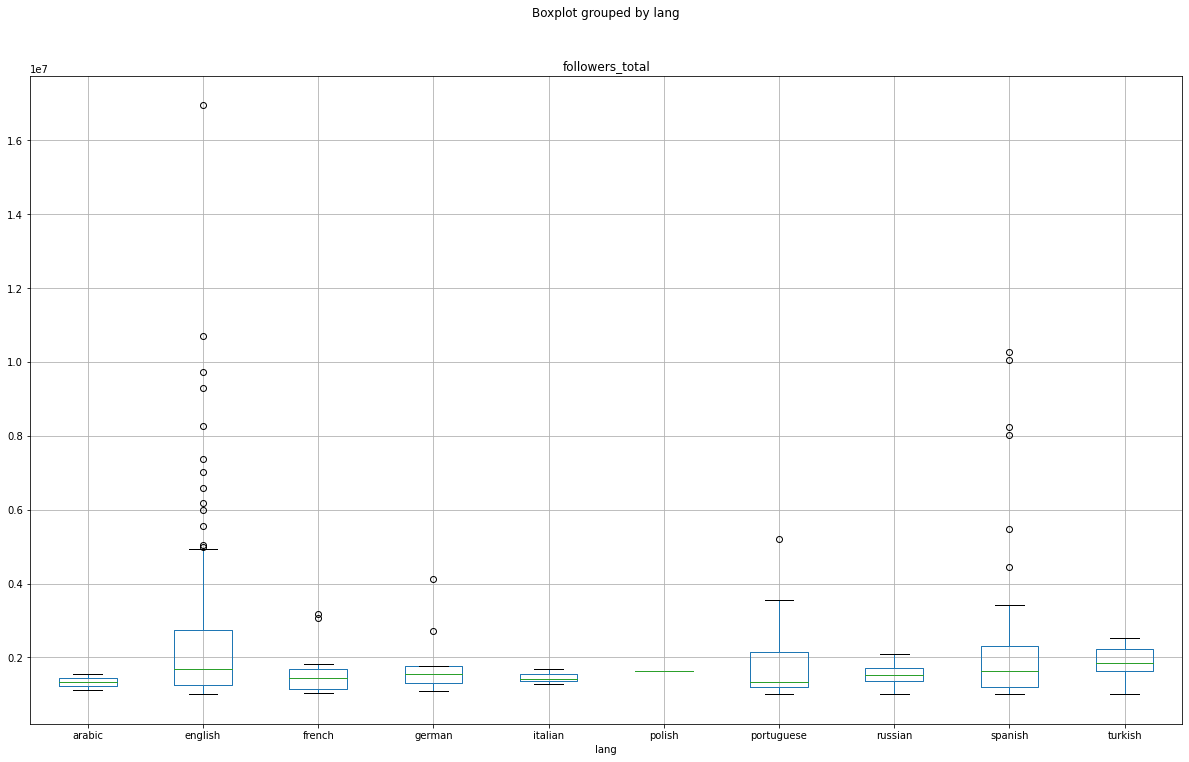

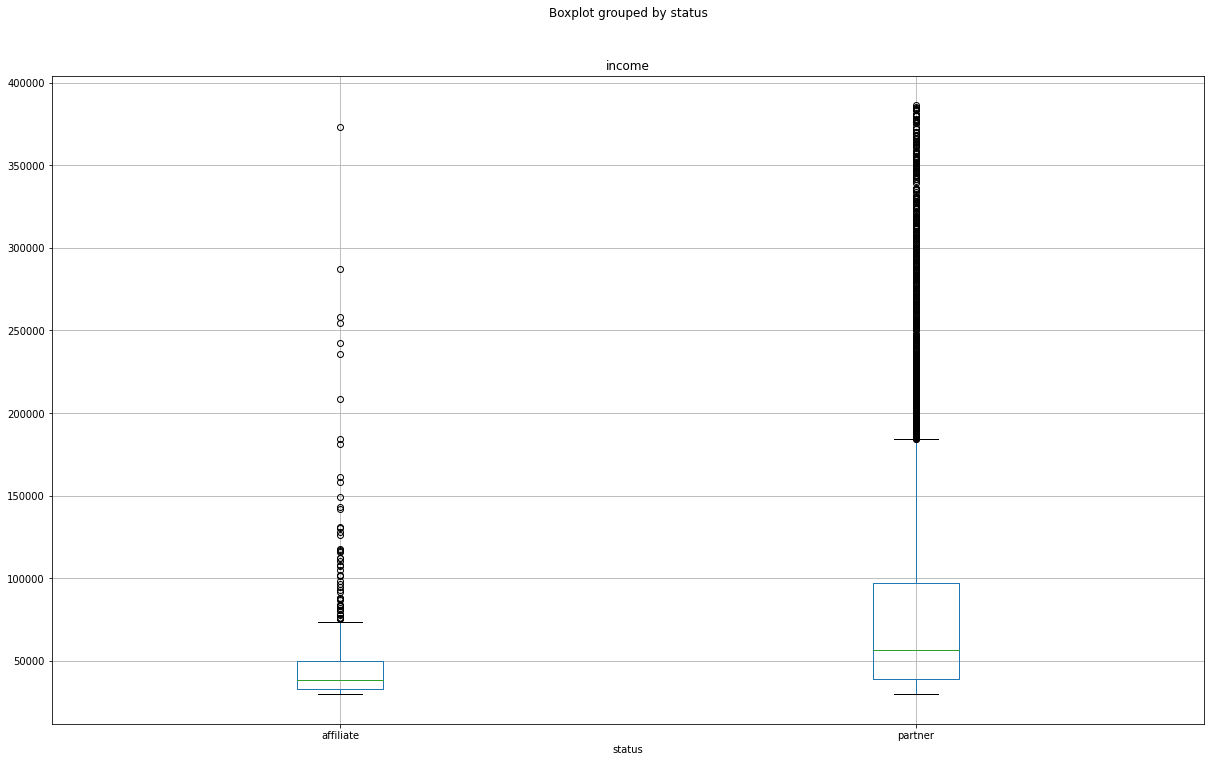

In [7]:
filtered_data = full_data[full_data['income'].between(full_data['income'].quantile(0), full_data['income'].quantile(.95))]
print('Russian streamers with income greater 130 000$:\n', full_data[full_data['income'] > 130_000][full_data['lang'] == 'russian'].head(15))
print('Russian followers above 800k:\n', full_data[full_data['followers_total'] >= 800_000][full_data['lang'] == 'russian'].head(15))
filtered_data.boxplot(column=['income'], by='lang', figsize=(20,12))
full_data[full_data['followers_total'] < 1_000_000].boxplot(column=['followers_total'], by='lang', figsize=(20,12))
full_data[full_data['followers_total'] >= 1_000_000].boxplot(column=['followers_total'], by='lang', figsize=(20,12))
filtered_data.boxplot(column=['income'], by='status', figsize=(20,12))

* Big variance in followers for Russian streamers.
* Partners' income bigger than affiliate, much more outliers.

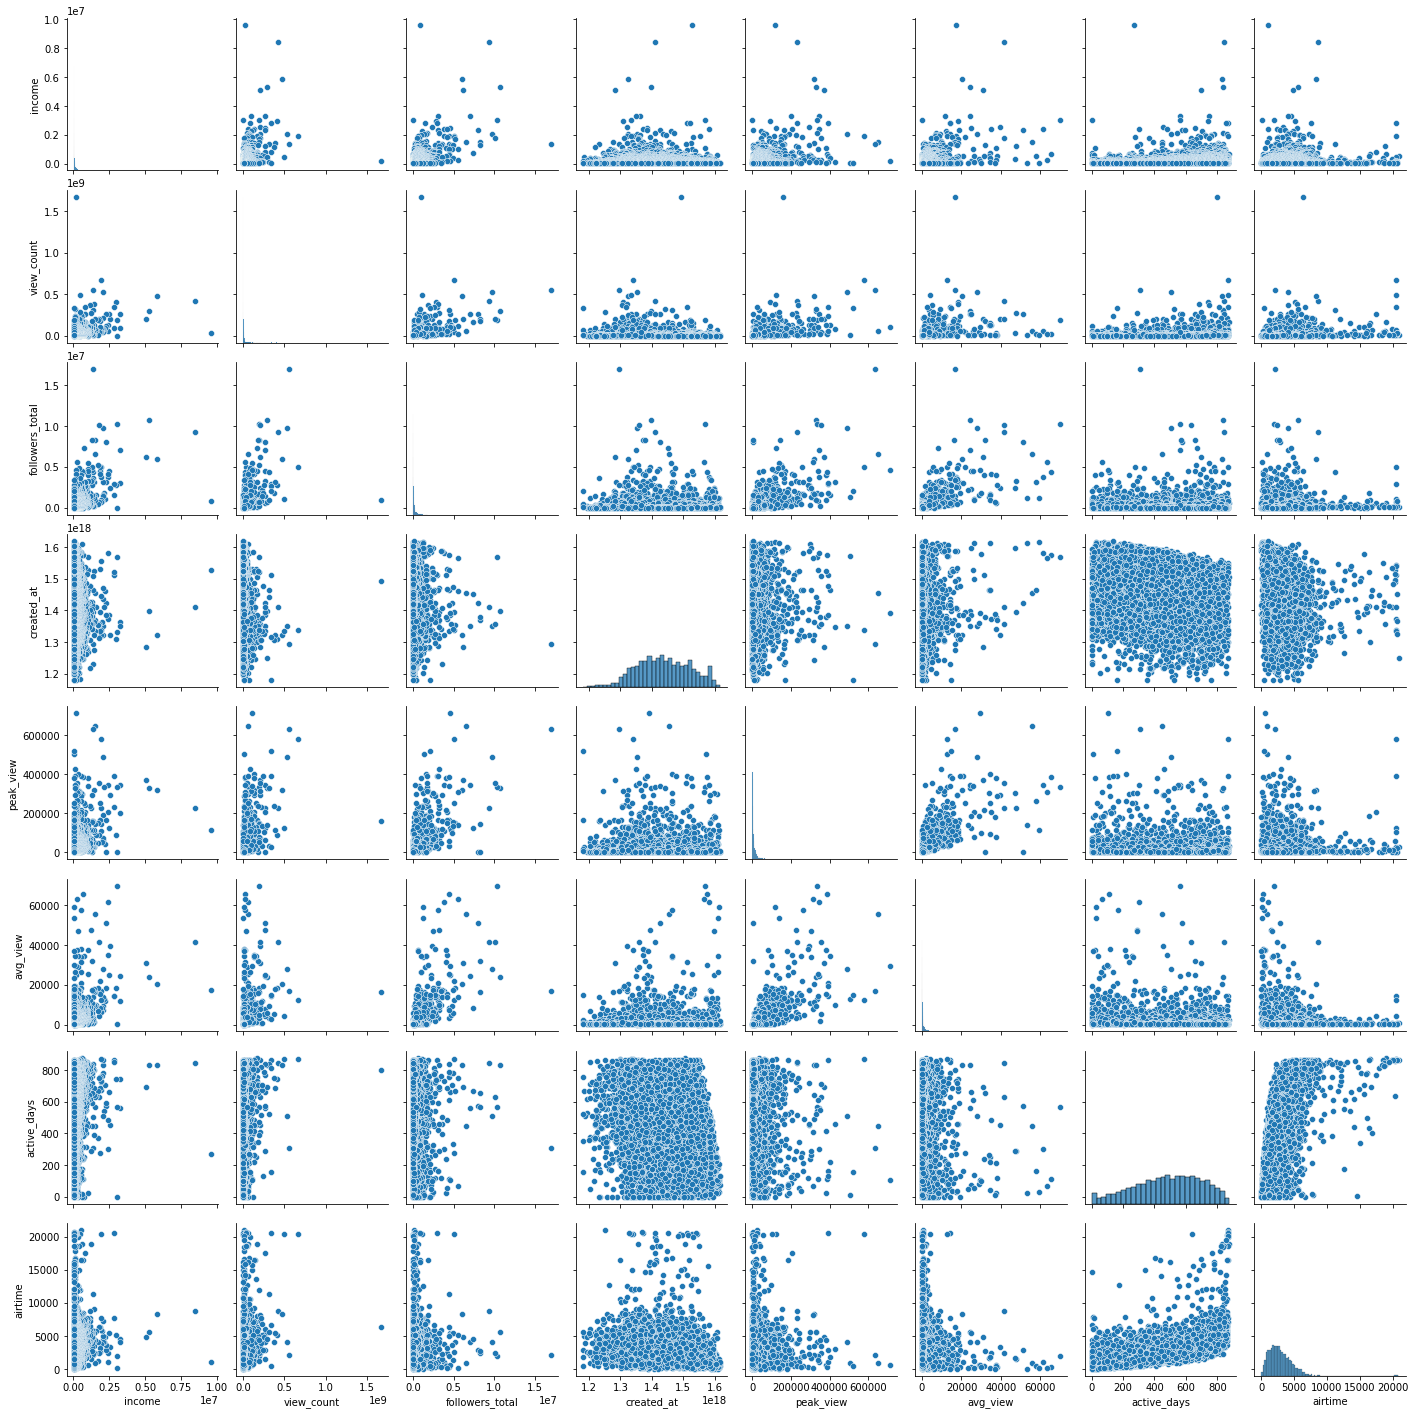

In [79]:
sns.pairplot(full_data.drop(['rank', 'user_id'], axis=1))

## Encode categorical variables

In [8]:
full_data = pd.get_dummies(full_data, columns=['status'])

## Checking correlation between variables
* Pearson
* Speraman (non-parametrical statistic)

<AxesSubplot:>

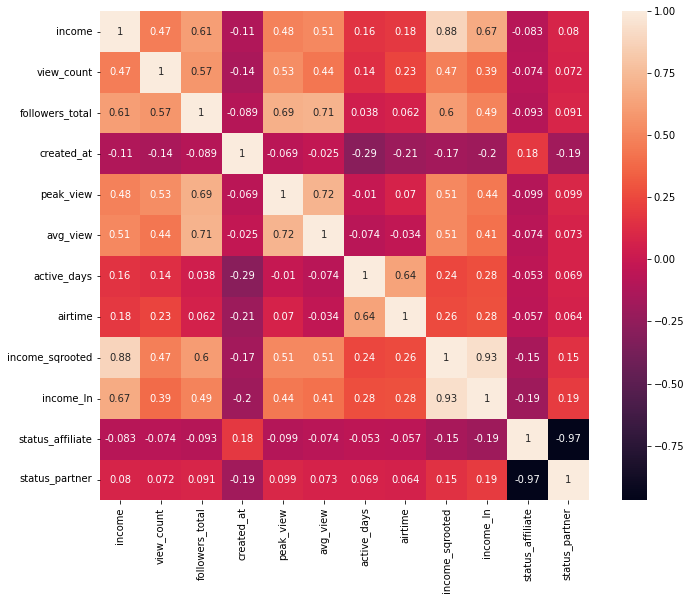

In [9]:
corrmat = full_data.drop(['rank', 'user_id', 'lang'], axis=1).corr(method='pearson')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True)

<AxesSubplot:>

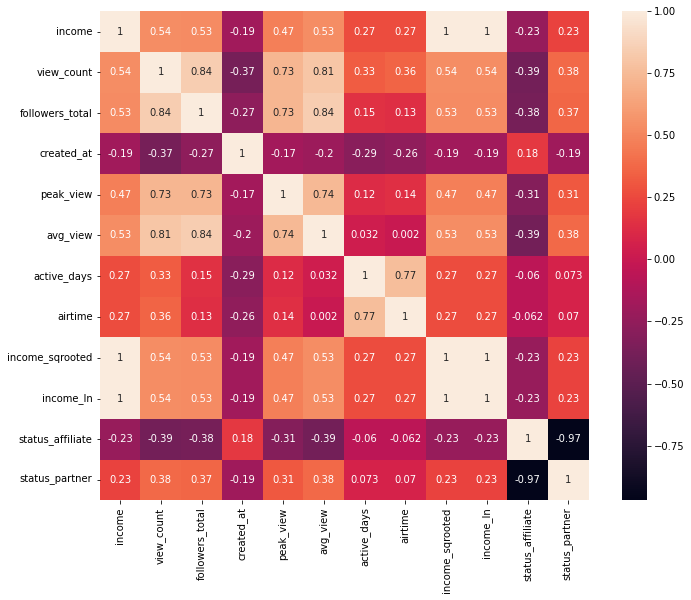

In [88]:
corrmat = full_data.drop(['rank', 'user_id', 'lang'], axis=1).corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True)

## QQ plot for income and followers_total

Attempted to normalize income variables:
1. Taking square root
2. Natural logarithm

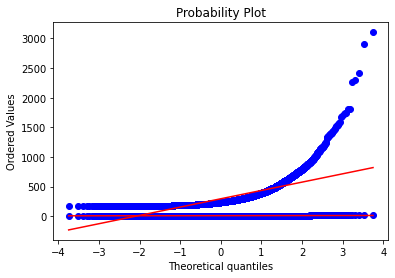

In [10]:
res = stats.probplot(full_data['income_ln'], plot=plt)
res = stats.probplot(full_data['income_sqrooted'], plot=plt)
# res = stats.probplot(full_data['followers_total'], plot=plt)

<AxesSubplot:>

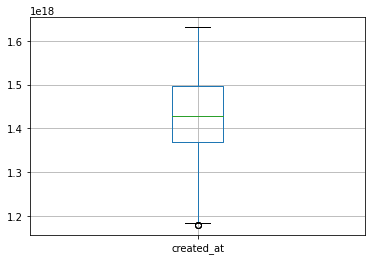

In [6]:
full_data.boxplot('created_at')
# res = stats.probplot(full_data['created_at'], plot=plt)

## Linear regression

In [11]:
from sklearn.linear_model import LinearRegression

# print(full_data.drop(['Unnamed: 0', 'income', 'rank', 'user_id', 'login'], axis=1).head())
drop_cols = ['income', 'rank', 'user_id', 'login', 'created_at', 'peak_view', 'lang', 'income_sqrooted', 'income_ln']

X = full_data.drop(drop_cols, axis=1)
y = full_data['income']

m = LinearRegression()
m.fit(X, y)
print('LinearRegression coeff:', m.coef_, 'for', X.columns)
print('Score:', m.score(X, y))

# karmikkoala
print('karmikkoala data:\n', full_data.loc[full_data['login'] == 'KarmikKoala'])
print('Predicted income:', m.predict(full_data.loc[full_data['login'] == 'KarmikKoala'].drop(drop_cols, axis=1))[0])

LinearRegression coeff: [ 1.05841022e-03  1.88815521e-01  1.41828147e+01  1.20045686e+02
  9.39106230e+00 -6.99499253e+04 -5.67160146e+04] for Index(['view_count', 'followers_total', 'avg_view', 'active_days', 'airtime',
       'status_affiliate', 'status_partner'],
      dtype='object')
Score: 0.4218188277857966
karmikkoala data:
      rank        login   user_id     income  view_count  followers_total  \
634   648  KarmikKoala  54742538  262640.87    23168119           170466   

              created_at  peak_view  avg_view  active_days  airtime     lang  \
634  1389379429000000000      10980      1984          647     4997  russian   

     income_sqrooted  income_ln  status_affiliate  status_partner  
634       512.484995  12.478543                 0               1  
Predicted income: 181140.66346769457


## PCA analysis

/var/folders/q7/5h3_bhz90vb4h0hngvk26txh0000gn/T/ipykernel_14803/1454240502.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  finalDf = finalDf[finalDf['income'] != 196503.25][finalDf['income'] != 1903580.27]


    principal component 1  principal component 2      income
44           5.433308e+08          -1.148054e+07  1378791.48
8            1.795745e+08          -8.332457e+06  3053341.54
33           1.966618e+08          -7.942474e+06  1764965.15
3            2.850304e+08          -7.730509e+06  5295582.44
55           1.682723e+08          -6.393477e+06  1286765.09


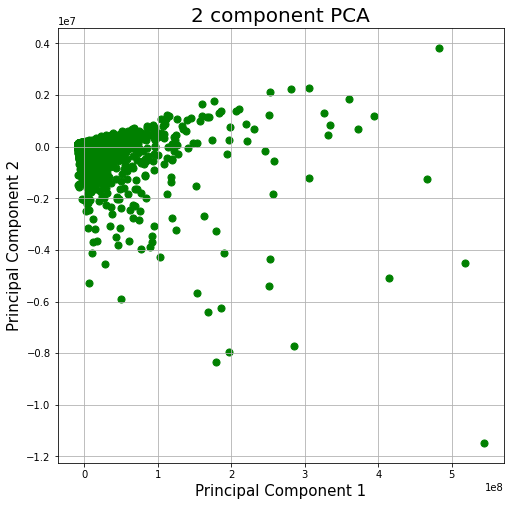

In [94]:
drop_cols = ['income', 'rank', 'user_id', 'login', 'created_at', 'peak_view', 'lang']

pca = PCA(n_components=2, svd_solver='full')
principalComponents = pca.fit_transform(full_data.drop(drop_cols, axis=1))

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, full_data[['income']]], axis = 1)
finalDf = finalDf[finalDf['income'] != 196503.25][finalDf['income'] != 1903580.27]

print(finalDf.sort_values('principal component 2', ascending=True).head())

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(finalDf['principal component 1']
            , finalDf['principal component 2']
            , c = "g"
            , s = 50)
ax.grid()



# print(principalComponents)